In [32]:
from matplotlib.animation import FuncAnimation

from plot import *


In [33]:
plot_variable_at_time_level_and_latitude_vs_longitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                                      time=0, level=71, latitude=180,
                                                      folder="compressed/wind")

In [34]:
plot_variable_at_time_level_and_longitude_vs_latitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                                      time=0, level=71, longitude=180,
                                                      folder="compressed/wind")

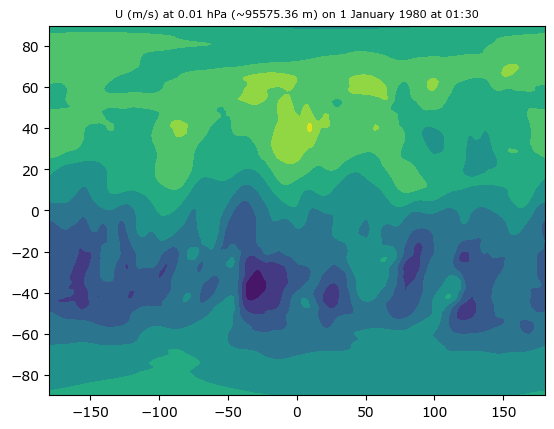

In [19]:
plot_contour_at_time_and_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U", time=0, level=0,
                               folder="compressed/wind")


In [31]:
%matplotlib notebook
plot_interactive_variable_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U", time=0, title="East Wind (m/s)",
                                  folder="compressed/wind")


<IPython.core.display.Javascript object>

In [ ]:
%matplotlib notebook
plot_interactive_variable_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V", time=0, title="North Wind (m/s)",
                                  folder="compressed/wind")


In [35]:
def _load_wind_data_at_time(filename, folder, time, contour_east, latitude_samples, longitude_samples):
    u_data = load_variable_at_time(filename, "U", time, folder=folder)
    v_data = load_variable_at_time(filename, "V", time, folder=folder)
    contour_data = (u_data if contour_east else v_data).copy()

    u_data = interpolate_variable_at_time(u_data, latitude_samples, longitude_samples)
    v_data = interpolate_variable_at_time(v_data, latitude_samples, longitude_samples)

    latitudes = np.linspace(0, u_data.shape[1], 361)
    longitudes = np.linspace(0, u_data.shape[2], 576)

    return u_data, v_data, contour_data, latitudes, longitudes


def plot_interactive_wind(filename: str, time: int,
                          folder: str = "compressed",
                          latitude_samples: int = 30,
                          longitude_samples: int | None = None,
                          contour_east: bool = True,
                          show_map: bool = True):
    u_data, v_data, contour_data, latitudes, longitudes = _load_wind_data_at_time(filename, folder, time, contour_east,
                                                                                  latitude_samples, longitude_samples)

    if show_map:
        coastlines, coastline_latitudes, coastline_longitudes = load_map(u_data.shape[1:])

    fig, ax, color_bar_ax, level_slider, resolution_slider = create_2_interactive_sliders_with_color_bar(
        "Wind Data (m/s)", 0, 71, 2, 32)

    def update(_):
        ax.clear()
        ax.set_yticks([])
        ax.set_xticks([])

        u_subdata = u_data[71 - level_slider.val]
        v_subdata = v_data[71 - level_slider.val]
        contour_subdata = contour_data[71 - level_slider.val]

        vmin, vmax = get_vmin_and_vmax(contour_subdata)

        contour = contourf(ax, resolution_slider.val, longitudes, latitudes, contour_subdata, vmin=vmin, vmax=vmax)
        fig.colorbar(contour, cax=color_bar_ax, fraction=0.05, pad=0.02)

        if show_map:
            draw_map(ax, coastlines, coastline_latitudes, coastline_longitudes)

        ax.barbs(u_subdata, v_subdata, barbcolor="#fff", flagcolor="#fff", length=3, linewidth=0.7)

    level_slider.on_changed(update)
    resolution_slider.on_changed(update)

    update(0)
    plt.show()


In [28]:
%matplotlib notebook
plot_interactive_wind("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", time=0, folder="compressed/wind")

<IPython.core.display.Javascript object>

In [36]:
def _plot_wind_at_level(ax, latitudes, longitudes, coastlines, coastline_latitudes, coastline_longitudes, u_data,
                        v_data, contour_data, level, show_map,
                        contour_levels: int = 32):
    ax.clear()
    ax.set_yticks([])
    ax.set_xticks([])

    if isinstance(level, int):
        u_subdata = u_data[71 - level]
        v_subdata = v_data[71 - level]
        contour_subdata = contour_data[71 - level]

        pressure = get_pressure_from_level(71 - level)

    elif isinstance(level, float):
        min_level = int(level)
        max_level = min_level + 1
        t = level % 1

        u_subdata = u_data[71 - max_level] * t
        u_subdata += u_data[71 - min_level] * (1 - t)
        v_subdata = v_data[71 - max_level] * t
        v_subdata += v_data[71 - min_level] * (1 - t)

        contour_subdata = contour_data[71 - max_level] * t
        contour_subdata += contour_data[71 - min_level] * (1 - t)

        pressure = get_pressure_from_level(71 - max_level) * t
        pressure += get_pressure_from_level(71 - min_level) * (1 - t)

    else:
        raise ValueError("level must be a number")

    contourf(ax, contour_levels, longitudes, latitudes, contour_subdata)

    if show_map:
        draw_map(ax, coastlines, coastline_latitudes, coastline_longitudes)

    ax.barbs(u_subdata, v_subdata, barbcolor="#fff", flagcolor="#fff", length=4, linewidth=0.6)
    ax.set_title(
        f"Wind at 1:30 AM on 1 January, 1980 at {pressure:.2f} hPa (~{height_from_pressure(100 * pressure):.2f} m)",
        color="#fff")


def plot_wind_at_level(filename: str, time: int, level: int,
                       folder: str = "compressed",
                       latitude_samples: int = 40,
                       longitude_samples: int | None = None,
                       contour_east: bool = True,
                       show_map: bool = True,
                       **kwargs):
    u_data, v_data, contour_data, latitudes, longitudes = _load_wind_data_at_time(filename, folder, time, contour_east,
                                                                                  latitude_samples, longitude_samples)

    px = 1 / plt.rcParams["figure.dpi"]
    fig, ax = plt.subplots(num="Wind Data",
                           figsize=(1728 * px, 1080 * px), facecolor=(0.1, 0.1, 0.1),
                           gridspec_kw={"left": 0, "right": 1, "bottom": 0, "top": 0.97, "hspace": 0, "wspace": 0})
    if show_map:
        coastlines, coastline_latitudes, coastline_longitudes = load_map(u_data.shape[1:])
    else:
        coastlines, coastline_latitudes, coastline_longitudes = None, None, None

    _plot_wind_at_level(ax, latitudes, longitudes, coastlines, coastline_latitudes, coastline_longitudes, u_data,
                        v_data, contour_data, level, show_map, **kwargs)
    plt.show()


In [ ]:
%matplotlib notebook
plot_wind_at_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", time=0, level=0, folder="compressed/wind")


In [37]:
def animate_wind_vs_level(filename: str, time: int,
                          folder: str = "compressed",
                          output_dir: str = "assets/graphs",
                          file_format: str = "mp4",
                          fps: int = 10,
                          latitude_samples: int = 40,
                          longitude_samples: int | None = None,
                          contour_east: bool = True,
                          show_map: bool = True,
                          interpolation_levels: int = 4,
                          **kwargs):
    u_data, v_data, contour_data, latitudes, longitudes = _load_wind_data_at_time(filename, folder, time, contour_east,
                                                                                  latitude_samples, longitude_samples)

    if show_map:
        coastlines, coastline_latitudes, coastline_longitudes = load_map(u_data.shape[1:])

    px = 1 / plt.rcParams["figure.dpi"]
    plt.clf()
    fig, ax = plt.subplots(num="Wind Data",
                           figsize=(1728 * px, 1080 * px), facecolor=(0.1, 0.1, 0.1),
                           gridspec_kw={"left": 0, "right": 1, "bottom": 0, "top": 0.97, "hspace": 0, "wspace": 0})

    def animate(i):
        print(f"Frame {i}")

        i /= interpolation_levels
        if i > 71:
            i = 142 - i
        _plot_wind_at_level(ax, latitudes, longitudes, coastlines, coastline_latitudes, coastline_longitudes, u_data,
                            v_data, contour_data, i, show_map, **kwargs)

    frames = 71 * interpolation_levels
    if file_format == "gif":
        frames *= 2

    anim = FuncAnimation(fig, animate, frames=frames, interval=1, blit=True)
    output_file = f"{'east' if contour_east else 'north'}-wind-{filename.split('.')[-2]}-{1 + time * 3:0>2}:30"
    anim.save(f"{output_dir}/{output_file}-{interpolation_levels}.{file_format}", fps=fps)


In [38]:
animate_wind_vs_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", time=0, folder="compressed/wind", contour_east=False)


<IPython.core.display.Javascript object>

Frame 0
Frame 0
Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 61
Frame 62
Frame 63
Frame 64
Frame 65
Frame 66
Frame 67
Frame 68
Frame 69
Frame 70
Frame 71
Frame 72
Frame 73
Frame 74
Frame 75
Frame 76
Frame 77
Frame 78
Frame 79
Frame 80
Frame 81
Frame 82
Frame 83
Frame 84
Frame 85
Frame 86
Frame 87
Frame 88
Frame 89
Frame 90
Frame 91
Frame 92
Frame 93
Frame 94
Frame 95
Frame 96
Frame 97
Frame 98
Frame 99
Frame 100
Frame 101
Frame 102
Frame 103
Frame 104
Frame 105
Frame 106
Frame 107
Frame 108
Frame 109
Fr